# 1. Setup

In [9]:
print("Starting setups")
import sys
import os

Starting setups


In [10]:
dir_path = os.getcwd()
parent_dir = os.path.dirname(dir_path)
home_dir = os.path.dirname(parent_dir)
print("dir_path is", dir_path)
print("parent_dir is", parent_dir)
print("home_dir is", home_dir)

dir_path is /Users/zoe/Documents/Bank-account-fraud/code/feature_engineering
parent_dir is /Users/zoe/Documents/Bank-account-fraud/code
home_dir is /Users/zoe/Documents/Bank-account-fraud


In [11]:
import yaml
print(home_dir+'/params.yaml')
with open(home_dir+'/params.yaml', 'r') as file:
    params = yaml.safe_load(file)
params

/Users/zoe/Documents/Bank-account-fraud/params.yaml


{'data_location': '/data',
 'output_location': '/output',
 'code_location': '/code'}

In [12]:
data_folder = home_dir+params['data_location']
print('Data is stored at', data_folder)

Data is stored at /Users/zoe/Documents/Bank-account-fraud/data


In [13]:
with open(dir_path+"/feature_flag.yaml", "r") as file:
    config = yaml.safe_load(file)["feature_engineering"]

print(f"Current configuration for feature engineering is: {config}")

Current configuration for feature engineering is: {'impute': True, 'one_hot_encoding': True, 'smote': True, 'smote_oversample_ratio': 0.8, 'smote_undersample_ratio': 1.0, 'robust_scaler': True, 'binning': True, 'outlier_handling': False, 'mutual_information': True, 'chi2_test': True}


## 1.1 Import libraries and reading data

In [14]:
print("Importing packages and reading data...")

sys.path.append(os.path.abspath("feature_engineering"))
from preprocessing import *

import pandas as pd
pd.set_option('display.max_columns', 500)

import warnings as wr
wr.filterwarnings('ignore')

Importing packages and reading data...


In [15]:
sys.path

['/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python311.zip',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11',
 '/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload',
 '',
 '/opt/homebrew/lib/python3.11/site-packages',
 '/Users/zoe/Documents/Bank-account-fraud/code/feature_engineering/feature_engineering']

In [16]:
df_base = pd.read_csv(f"{data_folder}/Base_backup.csv", header=0)
df = df_base.copy()

## 1.2 Drop features with no variance

In [17]:
constant_feature =[]
for x in df.columns:
    if df[x].nunique() == 1:
        constant_feature.append(x)
print("Dropping the constant features:", constant_feature)       
df = drop_columns(df, df[constant_feature])

Dropping the constant features: ['device_fraud_count']


### 1.3 Change the dataype of binary features into type boolean

In [18]:
print("Changing the dataype of binary features into type boolean")
binary_features = df.columns[df.nunique() == 2].tolist()

binary_features.remove('source')
# Convert these features"to boolean
df[binary_features] = df[binary_features].astype(bool)

# Verify changes
print(df[binary_features].dtypes)

Changing the dataype of binary features into type boolean
fraud_bool            bool
email_is_free         bool
phone_home_valid      bool
phone_mobile_valid    bool
has_other_cards       bool
foreign_request       bool
keep_alive_session    bool
dtype: object


## 1.3 Train test split

In [19]:
print("splitting train/test sets")
y = df['fraud_bool']
X = df.drop(columns=['fraud_bool'], axis = 1)

from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Training set (X_train) before feature engineering: {X_train.shape}")
print(f"Test set (X_test) before feature engineering: {X_test.shape}")
print(f"Training set (y_train) before feature engineering: {y_train.shape}")
print(f"Test set (y_test) before feature engineering: {y_test.shape}")

categorical_features, numerical_features = split_num_cat(df)
print('Categorical features before feature engineering:', categorical_features)
print('Numerical features before feature engineering:', numerical_features)

splitting train/test sets
Training set (X_train) before feature engineering: (800000, 30)
Test set (X_test) before feature engineering: (200000, 30)
Training set (y_train) before feature engineering: (800000,)
Test set (y_test) before feature engineering: (200000,)
Categorical features before feature engineering: ['income', 'customer_age', 'payment_type', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'month']
Numerical features before feature engineering: ['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes']


## 2. Switcher

In [20]:
print("Start feature eng  ineering steps...")

Start feature eng  ineering steps...


In [21]:
if config["impute"]:
    print("Applying imputation for missing values...")
    X_train, X_test = impute_missing_values(X_train, X_test)
else:
    print("Not applying imputation.")

Applying imputation for missing values...
Features with missing values represented by -1:
['prev_address_months_count', 'current_address_months_count', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
Train set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64

Test set null values after imputation:
prev_address_months_count       0
current_address_months_count    0
bank_months_count               0
session_length_in_minutes       0
device_distinct_emails_8w       0
dtype: int64
Training set shape after imputation: (800000, 32)
Test set shape after imputation: (200000, 32)


In [22]:
if config["one_hot_encoding"]:
    print("Applying one-hot encoding...")
    X_train, X_test = one_hot_encode(X_train, X_test)
else:
    print("Not applying one hot encoder.")

Applying one-hot encoding...
Categorical features to encode: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']
One-hot encoded training shape: (800000, 53)
One-hot encoded test shape: (200000, 53)


Applying binning...
the minimum value of bank_months_count is 0.0

 Bin Ranges:
Bin 1: [0.0, 1.0) -> Median: 0
Bin 2: [1.0, 5) -> Median: 2.5
Bin 3: [5, 9) -> Median: 6.5
Bin 4: [9, 13) -> Median: 10.5
Bin 5: [13, 17) -> Median: 14.5
Bin 6: [17, 21) -> Median: 18.5
Bin 7: [21, 25) -> Median: 22.5
Bin 8: [25, 29) -> Median: 26.5
Bin 9: [29, 33) -> Median: 30.5

 Bin medians and counts in training set:

bank_months_count_binned
0.0     202886
2.5     186125
6.5      37373
10.5     53539
14.5     51345
18.5     31604
22.5     30427
26.5    119801
30.5     86900
Name: count, dtype: int64


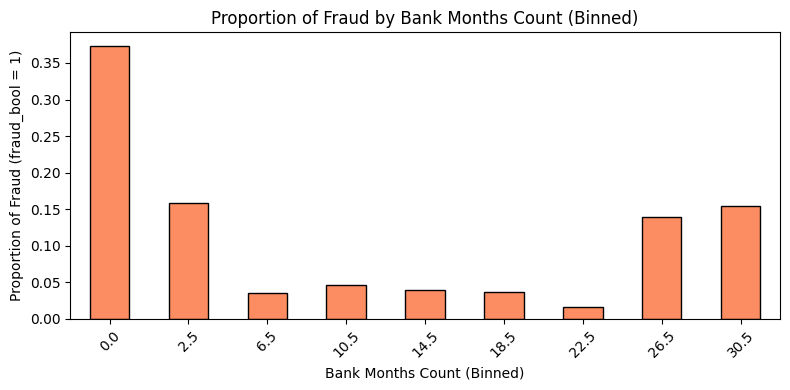

Final shape after binning - Train: (800000, 53), Test: (200000, 53)


In [23]:
if config["binning"]:
    print("Applying binning...")
    X_train, X_test = bin_bank_months_count(X_train, X_test, y_train)
else:
    print("Not applying binning.")

In [24]:
if config["robust_scaler"]:
    print("Applying robust scaling...")
    X_train, X_test = robust_scaler(X_train, X_test)
else:
    print("Not applying scaler.")

Applying robust scaling...
Categorical features: ['income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'month', 'bank_months_count_was_missing', 'prev_address_months_count_was_missing', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC', 'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG', 'source_INTERNET', 'source_TELEAPP', 'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'device_os_x11', 'bank_months_count_binned']
Numerical features: ['name_email_similarity', 'prev_address_months_count', 'current_address_mo

## PCA

### check nornality of numerical features

In principal component analysis, features with high variances or wide ranges get more weight than those with low variances, and consequently, they end up illegitimately dominating the first principal components (components with maximum variance).

In [27]:
categorical_features, numerical_features = split_num_cat(X_train)
numerical_features

['scaled_name_email_similarity',
 'scaled_prev_address_months_count',
 'scaled_current_address_months_count',
 'scaled_days_since_request',
 'scaled_intended_balcon_amount',
 'scaled_zip_count_4w',
 'scaled_velocity_6h',
 'scaled_velocity_24h',
 'scaled_velocity_4w',
 'scaled_bank_branch_count_8w',
 'scaled_date_of_birth_distinct_emails_4w',
 'scaled_credit_risk_score',
 'scaled_session_length_in_minutes']

In [33]:
for feature in numerical_features:
    mean = X_train[feature].mean()
    std = X_train[feature].std()
    X_train[feature] = (X_train[feature] - mean) / std

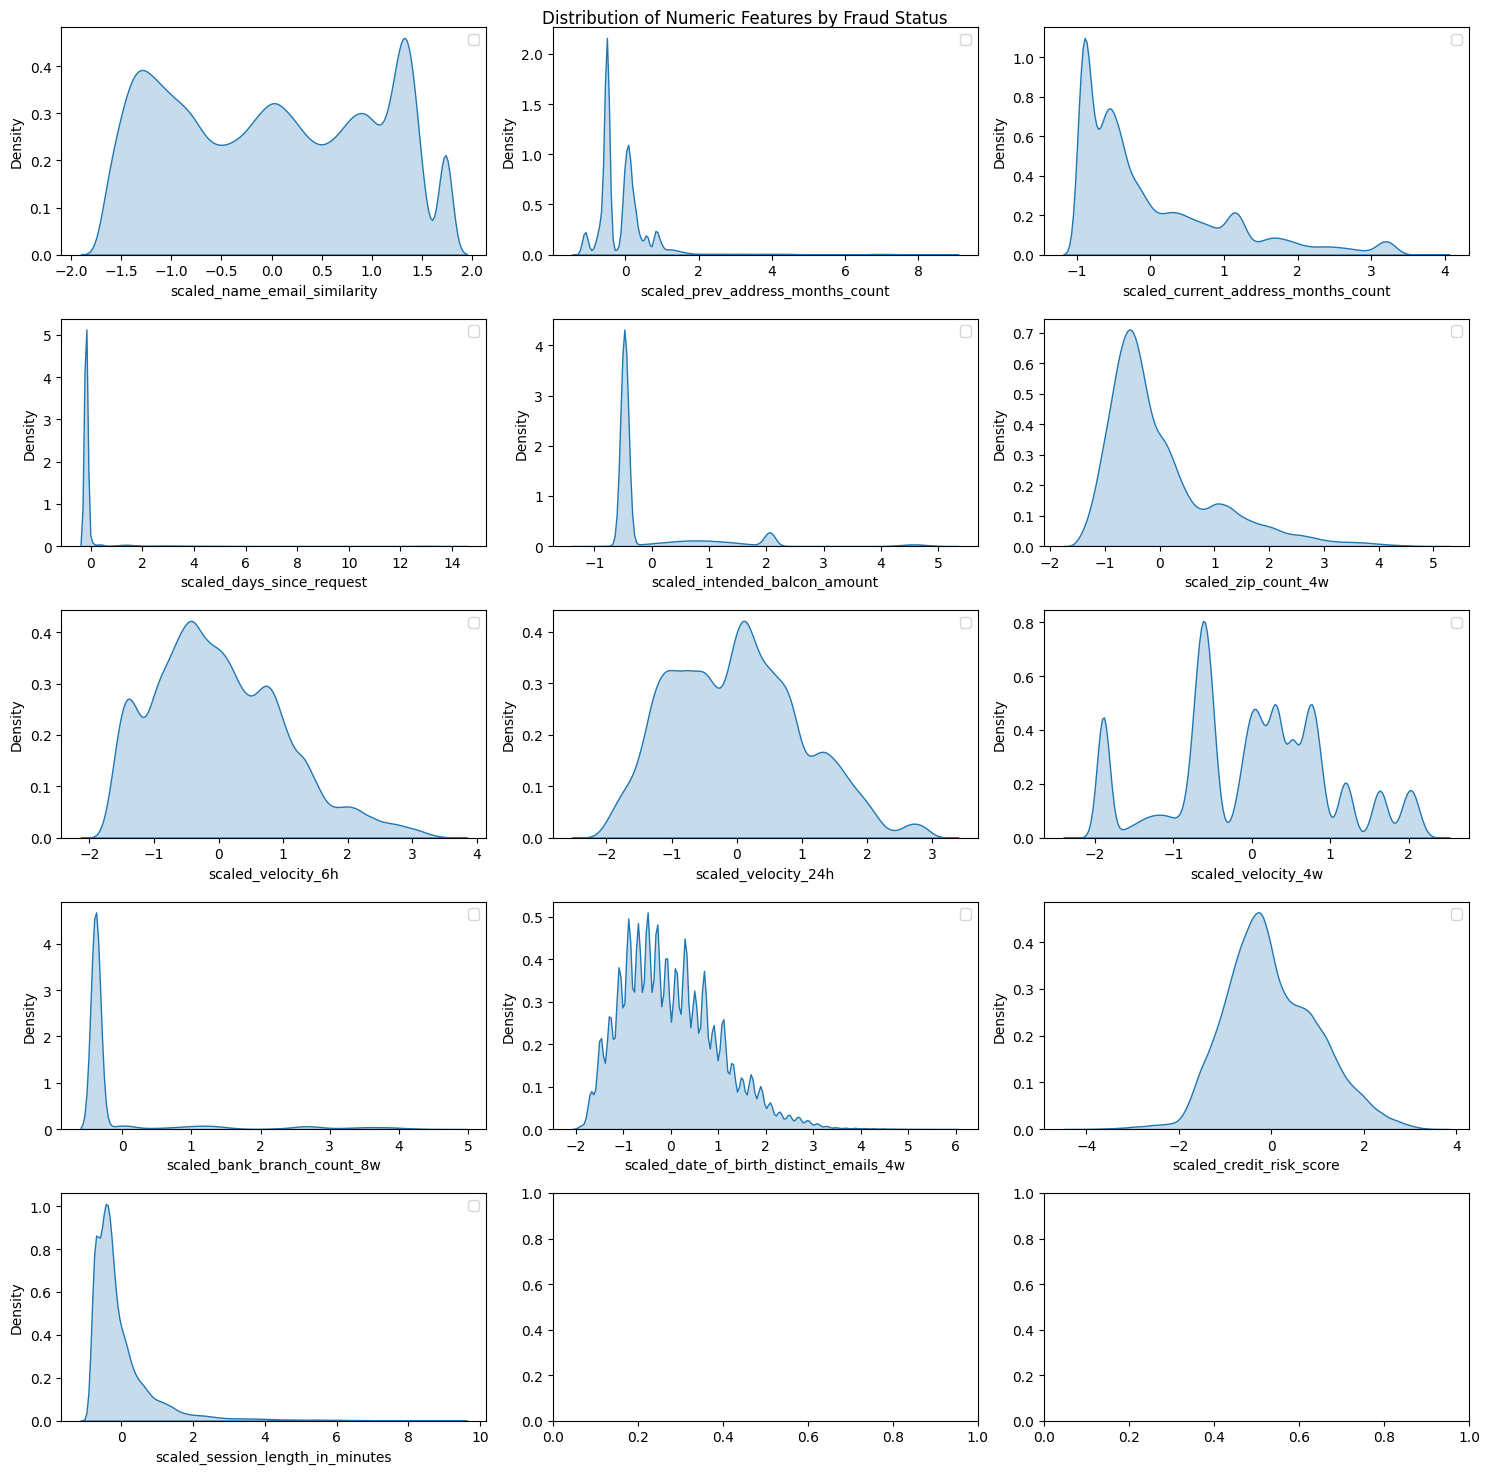

In [34]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))

# Add a title to the figure
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(numerical_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=X_train[feature], fill=True, ax=ax)
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [35]:
print(X_train[numerical_features].var())

scaled_name_email_similarity               1.0
scaled_prev_address_months_count           1.0
scaled_current_address_months_count        1.0
scaled_days_since_request                  1.0
scaled_intended_balcon_amount              1.0
scaled_zip_count_4w                        1.0
scaled_velocity_6h                         1.0
scaled_velocity_24h                        1.0
scaled_velocity_4w                         1.0
scaled_bank_branch_count_8w                1.0
scaled_date_of_birth_distinct_emails_4w    1.0
scaled_credit_risk_score                   1.0
scaled_session_length_in_minutes           1.0
dtype: float64


In [111]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X_train[numerical_features])

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,0.031197,-1.731224,-0.050509,0.294396,-1.180893,-0.259763,0.313438,0.069851,-0.694589,-0.756337,0.395629,-0.888010,0.051683
1,1.658459,-0.073348,-0.827739,0.385498,0.336134,0.673730,2.640674,0.649714,2.286101,-1.724332,-1.374664,0.866281,-0.594347
2,-0.182991,-1.735146,0.691131,1.257927,0.083663,-0.709899,-0.238949,-0.221240,-0.502122,0.702282,0.478117,-1.111189,-0.658300
3,-0.993214,-1.065426,-0.294523,0.203467,-1.266119,0.297302,0.623460,0.438862,1.138537,-0.838379,-0.898415,0.325985,-0.151327
4,-1.128439,0.123975,-1.938303,-0.150902,0.865760,-2.029294,1.400580,0.364491,-1.565603,1.160467,2.971293,-0.111029,0.308460
5,1.828266,-0.289448,-1.169531,0.508506,0.514718,-0.750623,1.446773,0.143501,-0.568493,-0.237380,-0.757820,0.179178,-0.645931
6,0.788211,-0.952793,-0.653620,-0.771308,0.997890,-0.359726,-1.172704,-0.919834,-0.576358,-0.006311,0.006232,-0.350142,-0.993509
7,-0.099854,-0.753999,-0.634093,-0.228486,-0.308503,0.316912,-0.155881,0.281171,0.465207,0.587654,-0.032950,-0.891692,0.501478
8,-0.257173,-1.508007,-0.181563,0.349634,-1.074262,-0.254710,-0.255987,0.078143,-1.111925,0.195396,0.116405,-0.204744,0.537988
9,-0.787083,-0.276741,1.021029,-0.405574,-0.677534,0.046268,-1.036661,1.026182,-0.082959,-0.761391,-0.113340,-0.372274,0.483072


In [112]:
# A component's loadings tell us what variation it expresses through signs and magnitudes:

loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train[numerical_features].columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
scaled_name_email_similarity,0.041973,0.151855,-0.186474,-0.210368,0.792361,-0.323427,0.135453,-0.280493,-0.099653,-0.223531,-0.082400,-0.000646,-0.000418
scaled_prev_address_months_count,-0.015628,0.486653,-0.122031,0.440310,-0.130532,-0.222502,0.107032,0.052637,-0.455955,0.243745,-0.453886,-0.002222,-0.007998
scaled_current_address_months_count,-0.017049,0.642539,-0.147287,0.103517,-0.125287,-0.050304,0.041985,-0.024045,0.106374,-0.163257,0.701771,0.029754,0.050385
scaled_days_since_request,0.052132,-0.121240,0.408305,0.541052,0.165946,-0.465581,-0.107854,-0.139529,0.435982,0.217593,0.101184,-0.006897,-0.003821
scaled_intended_balcon_amount,0.063541,0.237023,0.515589,-0.317960,0.109555,-0.240847,-0.158667,0.674475,-0.087631,-0.110246,-0.039023,0.036983,-0.005197
scaled_zip_count_4w,0.310258,0.058250,-0.201963,0.029980,-0.043000,0.013231,0.612794,0.302682,0.511352,-0.082162,-0.240411,0.219783,0.123159
scaled_velocity_6h,0.453821,0.096606,0.008938,-0.005459,-0.018691,0.106622,-0.396468,-0.192916,-0.022740,-0.032996,-0.078412,0.740998,-0.147138
scaled_velocity_24h,0.515027,0.101270,-0.004734,-0.044464,0.001428,0.097058,-0.269605,-0.097130,0.023493,0.052999,-0.079282,-0.380617,0.690241
scaled_velocity_4w,0.532495,0.064840,-0.072045,-0.032436,-0.000242,0.047083,-0.017952,0.023535,0.047195,0.094893,0.032493,-0.471042,-0.684646
scaled_bank_branch_count_8w,0.035743,0.203781,0.475254,-0.438835,-0.238741,-0.058859,0.388895,-0.495950,-0.011593,0.279466,-0.042964,0.031677,0.000772


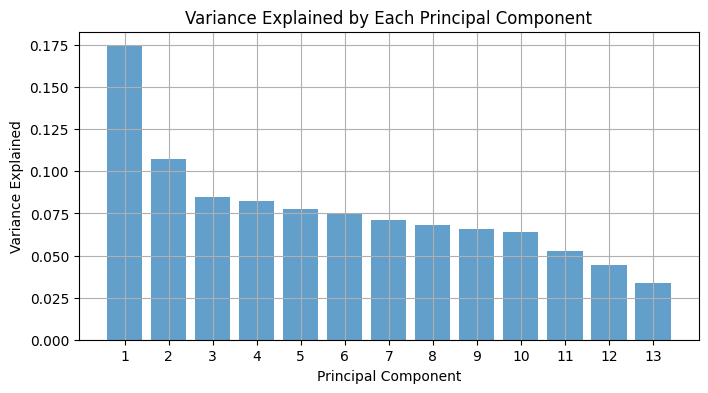

In [113]:
variance_explained = pca.explained_variance_ratio_
# Plotting the variance explained by each component
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.7, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, len(variance_explained) + 1))
plt.grid(True)
plt.show()

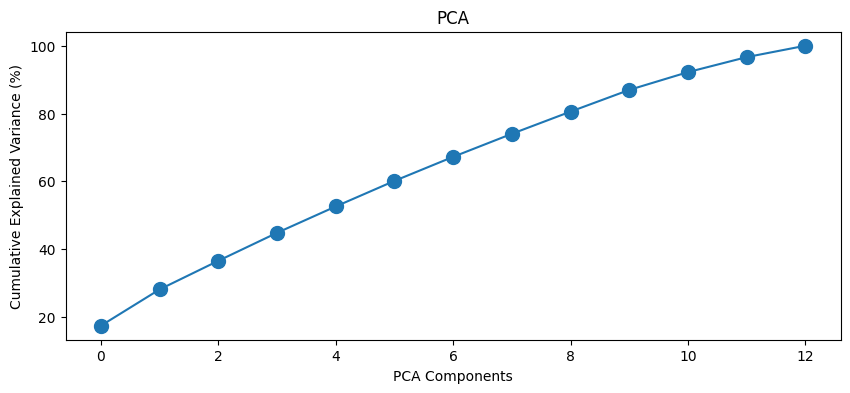

In [114]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]
plt.figure(figsize=(10, 4))
plt.plot(comp, cum_sum, marker='o',markersize=10)
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

In [115]:
variance_explained_first_two = sum(variance_explained[:13])
print("Variance explained by the 13 components:", variance_explained_first_two)

Variance explained by the 13 components: 1.0


Mutual Information Scores:
PC9     0.001999
PC6     0.001718
PC2     0.000734
PC10    0.000646
PC1     0.000531
PC4     0.000367
PC7     0.000194
PC11    0.000176
PC3     0.000165
PC13    0.000136
PC8     0.000131
PC5     0.000033
PC12    0.000000
Name: MI Scores, dtype: float64


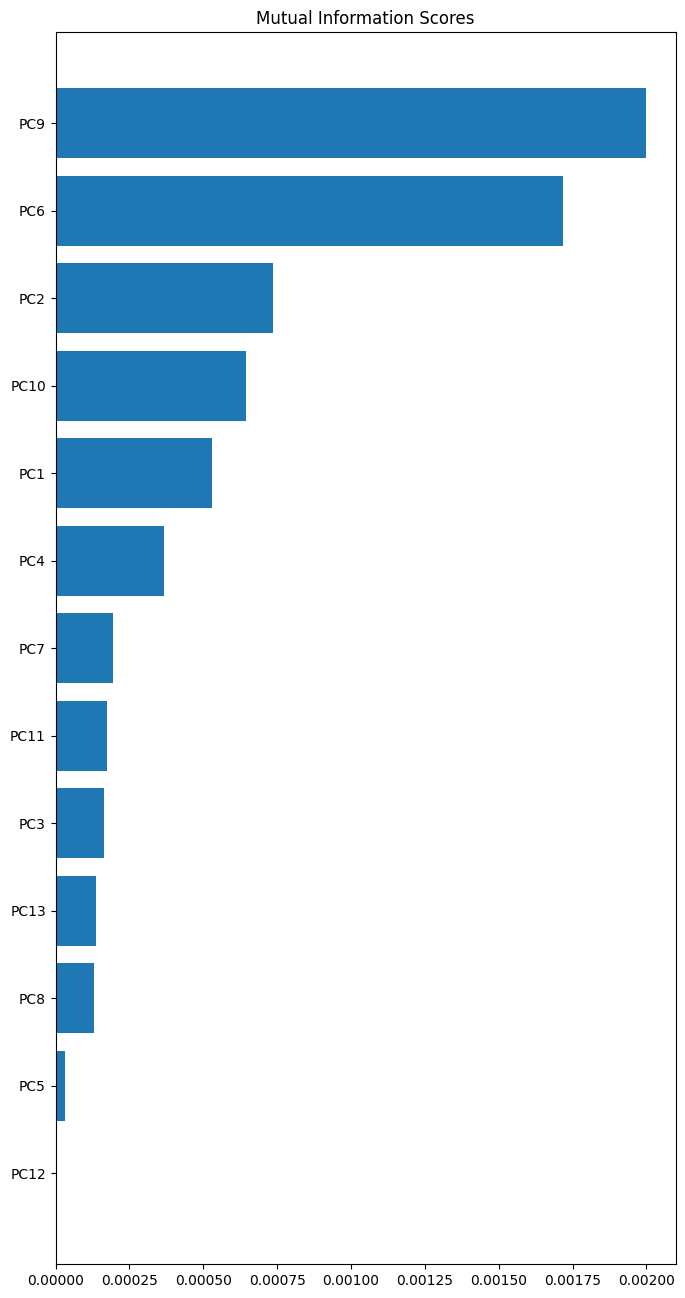

PC9     0.001999
PC6     0.001718
PC2     0.000734
PC10    0.000646
PC1     0.000531
PC4     0.000367
PC7     0.000194
PC11    0.000176
PC3     0.000165
PC13    0.000136
PC8     0.000131
PC5     0.000033
PC12    0.000000
Name: MI Scores, dtype: float64

In [116]:
mi_scores = mutual_information(X_pca, y_train)
mi_scores

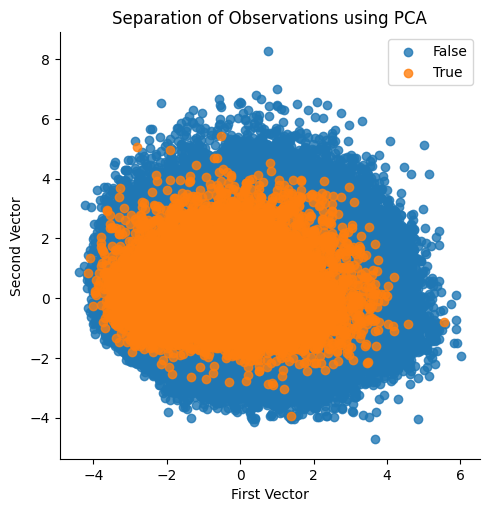

In [108]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:, 0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False, legend=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using " + algoName)
    ax.legend(loc = "upper right")
    
X_train_PCA = pca.fit_transform(X_train[numerical_features])
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)
X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, index=X_train.index)
scatterPlot(X_train_PCA, y_train, "PCA")

In [117]:
# Reconstructing the dataset
X_reconstructed = pca.inverse_transform(X_pca)

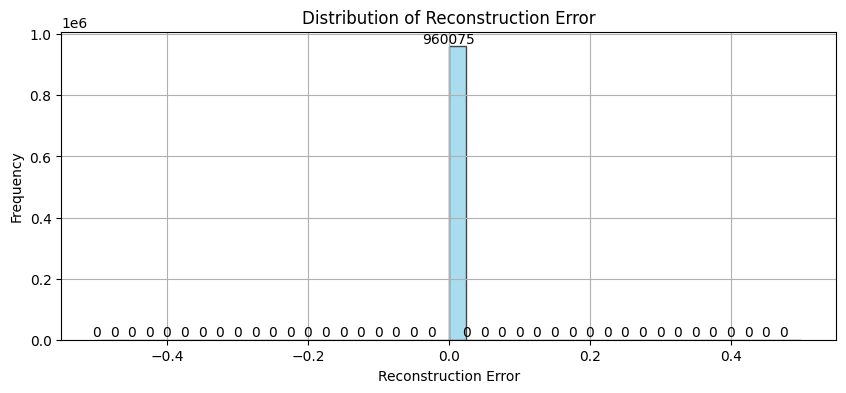

In [118]:
reconstruction_error = np.sum(np.square(X_train[numerical_features] - X_reconstructed), axis=1)
# Visualizing the reconstruction error
plt.figure(figsize=(10, 4))
counts, bins, _ = plt.hist(reconstruction_error, bins=40, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Error')
plt.grid(True)
# Annotate each bin with the count
for i in range(len(counts)):
    plt.text(bins[i], counts[i], str(int(counts[i])), ha='center', va='bottom', fontsize = 10)
plt.show()

In [101]:
threshold = np.percentile(reconstruction_error, 99.8)  # Adjust percentile as needed
threshold

np.float64(0.0)